In [104]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l1, l2, l1_l2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.linear_model import Ridge, Lasso
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgrey'

In [12]:
pd.set_option('display.max_columns', None)

pop_spotify = pd.read_pickle("data/spotify_df.pkl")

In [13]:
pop_spotify.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,month
95157,2c07kosP5G3qP4vHhwoUMT,In And Out Of Love - ilan Bluestone & Maor Lev...,30,263432,0,"['Armin van Buuren', 'Sharon Den Adel', 'Ilan ...","['0SfsnGyD8FpIN4U4WCkBZ5', '2GST08xzn3dJilysjD...",2020-12-11,0.352,0.736,1,-4.781,1,0.1300,0.01930,0.000020,0.3600,0.102,129.987,4,2020,12
87847,1wd5l8qYJ4AlgAhPGQxZq4,Im,30,228069,0,['Alma Zohar'],['61Sbigb2Faz8K27wBoOBo9'],2015-07-15,0.702,0.572,7,-9.597,1,0.0289,0.25900,0.000000,0.0946,0.327,129.985,4,2015,7
86833,3n1vpIDGakzAbo2p2etvhN,Taras e manias,30,248813,0,['Marco Paulo'],['5LxTQtpFwvokioLWNkrDQr'],2013-01-14,0.613,0.558,11,-6.149,1,0.0387,0.53200,0.000000,0.1260,0.529,110.069,4,2013,1
95155,0MbIwfFvlLpK2yW6w3kmbd,Time Machine (Mixed),30,49676,0,"['Craig Connelly', 'Tara Louise']","['78UUH1buA0gDtDnkX2dPgL', '6rCzXE6L3H7Eihb4Bg...",2020-12-11,0.508,0.887,4,-8.721,0,0.1370,0.00441,0.987000,0.1270,0.648,135.215,4,2020,12
79426,6WmvWYAnshYAAXZRD1hqck,Eime Enas Allos - Original,30,214693,0,['Nino Xypolitas'],['1ATDcv6wTF2U42HPB4qEFz'],2006-01-01,0.644,0.996,11,-5.938,1,0.1030,0.00346,0.000001,0.3680,0.517,142.995,4,2006,1


In [14]:
samp = np.random.randint(low=0,high=1900000,size=100000)
samp

array([  93084, 1736482,  123806, ..., 1017362, 1492844, 1293165])

In [15]:
sample_df = pop_spotify.iloc[samp]

In [16]:
samp_df2 = sample_df[['popularity','duration_ms','explicit','danceability','energy','key','loudness','mode', 'speechiness','acousticness','instrumentalness','liveness','valence','tempo']]

In [17]:
# samp_df2[samp_df2['tempo'] - np.mean(samp_df2['tempo'] / np.std(samp_df2['tempo']))] 

In [18]:
# pop_df = pop_spotify[['popularity','danceability', 'instrumentalness', 'loudness', 'speechiness', 'explicit','liveness','duration_ms']]

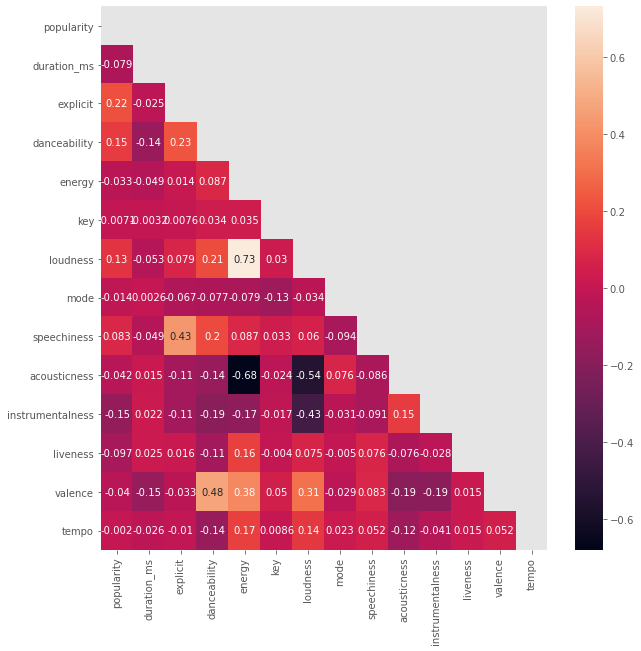

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(samp_df2.corr(), annot=True, mask=np.triu(samp_df2.corr()));

In [20]:
# dance = pop_df[['popularity','danceability']]
# avg_dance = pop_df.groupby('popularity').mean()

In [21]:
# fig, ax = plt.subplots(figsize=(14,5),squeeze=True)

# ax.plot(avg_dance.index, avg_dance.danceability,color='navy',alpha=0.5)
# ax.scatter(avg_dance.index, avg_dance.danceability,color='blue',s=20)
# ax.set_title('Average Danceability as Popularity Increases')
# ax.set_xlabel('Popularity')
# ax.set_ylabel('Danceability')
# plt.plot(np.unique(avg_dance.index), np.poly1d(np.polyfit(avg_dance.index, avg_dance.danceability, 1))(np.unique(avg_dance.index)),linestyle='--');
# plt.tight_layout()
# plt.show()

In [22]:
# r,p = stats.pearsonr(avg_dance.index,avg_dance.danceability)
# r,p

In [23]:
def rmse(y_true, y_predict):
    return mean_squared_error(y_true, y_predict)

In [24]:
def msle(y_true, y_predict):
    return mean_squared_log_error(y_true, y_predict)

In [25]:
def cross_val(X_train, y_train, k, model):
    # Return the error for k-fold cross-val
    kf = KFold(n_splits=k)
    error = np.empty(k)
    index = 0
    
    for train, test in kf.split(X_train):
        model.fit(X_train[train], y_train[train])
        pred = model.predict(X_train[test])
        error[index] = rmse(y_train[test], pred)
        index +=1
    return np.mean(error)

In [26]:
y = samp_df2.popularity
X = samp_df2.drop(['popularity'], axis=1)


In [27]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Columns'] = X.columns
vif_info.sort_values('VIF')

,VIF,Columns
9,1.420720,instrumentalness
1,1.611488,explicit
7,2.425764,speechiness
10,2.555725,liveness
6,2.730995,mode
8,3.011860,acousticness
4,3.214516,key
5,8.140998,loudness
11,8.714075,valence
0,9.255921,duration_ms


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, shuffle=True, test_size=0.2, random_state=42)

In [39]:
lr = LinearRegression().fit(X_train, y_train)
# y_hats = lr.predict(X_train)
lr.score(X_test,y_test)

0.11674136803785351

In [40]:
ridge1 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge1.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge1.score(X_test, y_test)))

Training set score: 0.11
Test set score: 0.12


In [41]:
ridge2 = Ridge(alpha=.1).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge2.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge2.score(X_test, y_test)))

Training set score: 0.11
Test set score: 0.12


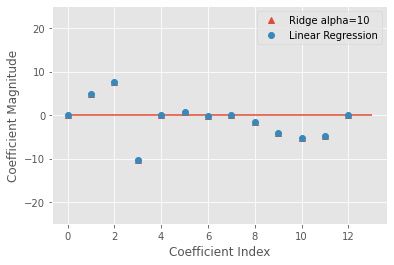

In [42]:
plt.plot(ridge1.coef_,'^',label="Ridge alpha=10")
plt.plot(lr.coef_,'o', label="Linear Regression")

plt.xlabel("Coefficient Index")
plt.ylabel("Coefficient Magnitude")
plt.hlines(0,0,len(lr.coef_))
plt.ylim(-25, 25)
plt.legend()

# Random Forest


n_estimators:
200: .79532
100: .79234
50: .79260
400: .796

In [63]:
# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [16,32,64,128]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}



In [64]:
# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, cv=3,random_state=42, n_jobs=-1)
# rf_random.fit(X_train,y_train)

## Training

In [130]:
rfr = RandomForestRegressor(n_estimators=50)
model = rfr.fit(X_train,y_train)
y_hats = model.predict(X_train)
print('R-Squared Train:', model.score(X_train,y_train))
print('MSLE Train:', msle(y_train, y_hats))


R-Squared Train: 0.958821485250213
MSLE Train: 0.0023521458171484474


### Cross-validation on training data

In [66]:
# print('Cross-validation Train:', cross_val(X_train, y_train, k=7, model=RandomForestRegressor()))

## Testing

In [131]:
y_hats = model.predict(X_test)
print('R-Squared Test:', model.score(X_test,y_test))
print('MSLE Test:', msle(y_test,y_hats))

R-Squared Test: 0.7978132878385042
MSLE Test: 0.01050968726977014


* With **Testing Accuracy** < **Training Accuracy**, this indicates an overfitting of the model. Need to generalize the model more.

### Cross-validation on testing data

In [68]:
# print('Cross-validation Test:', cross_val(X_test, y_test, k=7, model=RandomForestRegressor()))

# Neural Network

In [30]:
X_train.shape, y_train.shape

((80000, 13), (80000,))

In [32]:
y_train.reshape(80000,13)

ValueError: cannot reshape array of size 80000 into shape (80000,13)

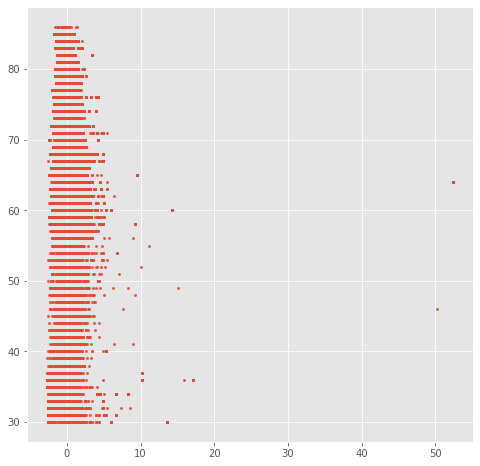

In [34]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X_train[:,0],y_train, s=5)

(20000, 13)

In [96]:
sc = StandardScaler()
# X_train_scale = sc.fit_transform(X_train)
# X_train = sc.inverse_transform(X_train_scale)
# X_test_scale = sc.fit_transform(X_test)
# X_test = sc.inverse_transform(X_test_scale)

In [97]:
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [98]:
model = Sequential()

In [99]:
model.add(Dense(200, kernel_regularizer=l1(0.01),activation = 'relu', input_shape = (13, 1)))
model.add(Dense(units = 50, kernel_regularizer=l1(0.01), activation = 'relu'))
model.add(Dropout(0.50))
model.add(Dense(units = 50, kernel_regularizer=l1(0.01),activation = 'relu'))
model.add(Dropout(0.50))
model.add(Dense(units = 50, kernel_regularizer=l1(0.01),activation = 'relu'))
model.add(Dropout(0.50))
model.add(Dense(units = 50, kernel_regularizer=l1(0.01),activation = 'relu'))
model.add(Dense(units = 1, kernel_regularizer=l1(0.01),activation = 'linear'))

In [100]:
#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_logarithmic_error')

In [101]:
pop_mod = model.fit(X_train.reshape(X_train.shape[0],X_train.shape[1], 1), 
          y_train, 
          epochs=20, 
          batch_size=32, 
          validation_data = (X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test), 
          callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    verbose=1,
                                                    patience=4,
                                                    restore_best_weights=True))

Epoch 1/20
2500/2500 [==============================] - 13s 4ms/step - loss: 5.3758 - val_loss: 0.6824
Epoch 2/20
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6356 - val_loss: 0.2365
Epoch 3/20
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2605 - val_loss: 0.1533
Epoch 4/20
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1771 - val_loss: 0.1355
Epoch 5/20
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1444 - val_loss: 0.1274
Epoch 6/20
2500/2500 [==============================] - 11s 5ms/step - loss: 0.1285 - val_loss: 0.1209
Epoch 7/20
2500/2500 [==============================] - 11s 5ms/step - loss: 0.1194 - val_loss: 0.1141
Epoch 8/20
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1132 - val_loss: 0.1088
Epoch 9/20
2500/2500 [==============================] - 11s 5ms/step - loss: 0.1077 - val_loss: 0.1041
Epoch 10/20
2500/2500 [==============================] - 11s 4ms/step - l

In [102]:
train_msle = model.evaluate(X_train.reshape(X_train.shape[0],X_train.shape[1], 1), y_train, verbose=0)
test_msle = model.evaluate(X_test.reshape(X_test.shape[0],X_test.shape[1], 1), y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_msle, test_msle))

Train: 0.081, Test: 0.081


## Visualizing Loss in my neural network

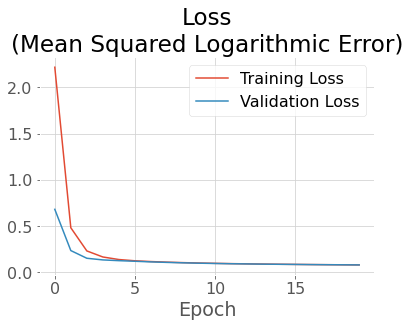

In [105]:
metrics = pop_mod.history

plt.plot(pop_mod.epoch, metrics['loss'], metrics['val_loss'])

plt.title("Loss\n(Mean Squared Logarithmic Error)")
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.show()

In [25]:
# pred = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

In [37]:
# def chart_regression(pred, y, sort=True):
#     t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
#     if sort:
#         t.sort_values(by=['y'], inplace=True)
#     plt.plot(t['y'].tolist(), label='expected')
#     plt.plot(t['pred'].tolist(), label='prediction')
#     plt.ylabel('output')
#     plt.legend()
#     plt.show()

In [65]:
# def plot_results(model, ax=None, function=np.sin, xlim=(-7, 7)):
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(12,5))
        
#     y_pred = model.predict(X_test.reshape(20000,-1))
#     ax.plot(X_test, y_pred, 'r-', label='Model Predictions')
#     ax.plot(X_test, y_test, 'b-', lw=1, label='Actual Expected Values')
    
#     ax.axvline(-5, color='k', label='Limites of Data')
#     ax.axvline(5, color='k')
#     ax.set_xlim(xlim)
#     ax.legend()

In [74]:
# fig, ax = plt.subplots(figsize=(12,5))
# plot_results(model, ax=ax)